# Book version 따라가기
- https://www.learnpytorch.io/03_pytorch_computer_vision/
- 일단 무지성으로 책 내용을 쭉 따라가 본다

### Image data의 형태와 성능
- Image data는 보통 다음과 같은 형태로 전달 된다
    - NCHW (Num image-Color channels-Height-Width)
    - NHWC
- 보통 NCHW로 주어지는 것 보다 NHWC로 주어지는게 더 효과적이다
    - NCHW로 되어 있다면 [c][h][w]와 [c+1][h][w] 사이의 간격이 HW가 된다
    - NHWC로 되어 있다면 [h][w][c]와 [h][w][c+1] 사이의 간격이 1이 된다
    - 즉 여러 color channel을 동시에 고려하는 feature가 있을 때 NHWC쪽이 훨씬 더 효율적인 메모리 접근이 가능하다

In [56]:
import torch
import torch.nn
import torchvision
import torchvision.datasets
import torchvision.transforms

import matplotlib.pyplot

print(f'PyTorch version: {torch.__version__}')

PyTorch version: 2.1.1+cu121


In [57]:
# 1. Getting a dataset
# download FashionMNIST dataset

# Setup training data
train_data = torchvision.datasets.FashionMNIST(
    root="data_FashionMNIST", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=torchvision.transforms.ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = torchvision.datasets.FashionMNIST(
    root="data_FashionMNIST",
    train=False, # get test data
    download=True,
    transform=torchvision.transforms.ToTensor()
)

print(f'len(train_data.data):    {len(train_data.data)}')
print(f'len(train_data.targets): {len(train_data.targets)}')
print(f'len(test_data.data):     {len(test_data.data)}')
print(f'len(test_data.targets):  {len(test_data.targets)}')

print(f'train_data.classes = {train_data.classes}')
print(f'test_data.classes  = {test_data.classes}')

len(train_data.data):    60000
len(train_data.targets): 60000
len(test_data.data):     10000
len(test_data.targets):  10000
train_data.classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
test_data.classes  = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


image.shape = torch.Size([1, 28, 28])
label = 9 (Ankle boot)


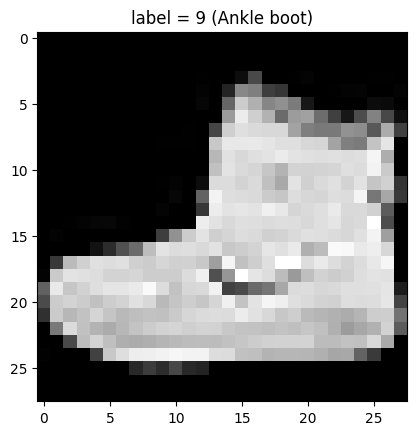

In [58]:
# Visualizing data

image, label = train_data[0]
print(f'image.shape = {image.shape}') # [color_chanels=1 (grayscale), height=28, width=28]
print(f'label = {label} ({train_data.classes[label]})')
matplotlib.pyplot.imshow(image.squeeze(), cmap='gray')
matplotlib.pyplot.title(f'label = {label} ({train_data.classes[label]})')
matplotlib.pyplot.show()

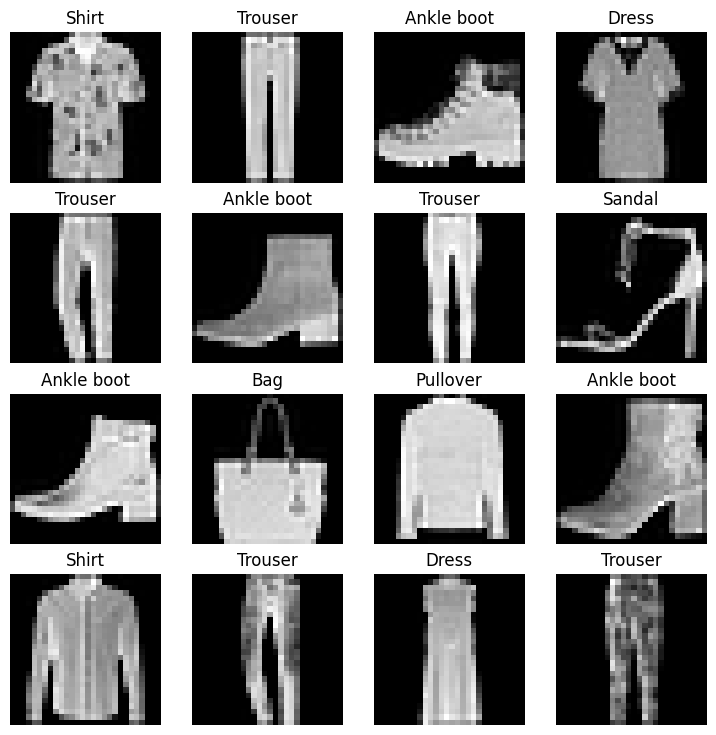

In [59]:
# Plot more images
torch.manual_seed(20240104)
fig = matplotlib.pyplot.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(rows * cols):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i+1)
    matplotlib.pyplot.imshow(img.squeeze(), cmap="gray")
    matplotlib.pyplot.title(train_data.classes[label])
    matplotlib.pyplot.axis(False) # hide all axis decorations

matplotlib.pyplot.show()

In [60]:
# 2. Creating a DataLoader

import torch.utils.data

BATCH_SIZE = 32

print(f'type(train_data) = {type(train_data)}')

# torch.utils.data.DataLoader는 __getitem__으로 접근했을때 image, label을 리턴해 준다면 그걸로 호환된다
# https://tutorials.pytorch.kr/beginner/basics/data_tutorial.html

train_dataloader = torch.utils.data.DataLoader(
    train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=True # shuffle data every epoch?
)

test_dataloader = torch.utils.data.DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
print(f'train_features_batch.shape = {train_features_batch.shape}') # torch.Size([32, 1, 28, 28])
print(f'train_labels_batch.shape = {train_labels_batch.shape}') # torch.Size([32])


type(train_data) = <class 'torchvision.datasets.mnist.FashionMNIST'>
Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f02d86e9150>, <torch.utils.data.dataloader.DataLoader object at 0x7f02d8480e90>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32
train_features_batch.shape = torch.Size([32, 1, 28, 28])
train_labels_batch.shape = torch.Size([32])


In [61]:
# 3. Model 0: Build a baseline model

flatten_model = torch.nn.Flatten()

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x)

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening : {output.shape} -> [color_channels, height*width]")

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening : torch.Size([1, 784]) -> [color_channels, height*width]


In [62]:
class FashionMNISTModelV0(torch.nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = torch.nn.Sequential(
            torch.nn.Flatten(), # neural networks like their inputs in vector form
            torch.nn.Linear(in_features=input_shape, out_features=hidden_units),
            torch.nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)
    
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [63]:
# Need to setup model with input parameters
model_0 = FashionMNISTModelV0(input_shape=784, # one for every pixel (28x28)
    hidden_units=10, # how many units in the hiden layer
    output_shape=len(train_data.classes) # one for every class
)
model_0.to("cpu") # keep model on CPU to begin with 

#
# torch.nn.CrossEntropyLoss는 loss를 계산할때 pred는 probability distribution vector, label은 class index로 줘도 된다
#

loss_fn   = torch.nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [64]:
# tqdm quick example - progress bar가 나온다
import time
from tqdm.auto import tqdm

for i in tqdm(range(10)):
    time.sleep(0.5)

100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


In [65]:
from timeit import default_timer as timer 
# Import tqdm for progress bar
from tqdm.auto import tqdm

train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 3

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train() 
        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 400 == 0:  # 각 batch는 32개이므로 32*400 = 12800 sample에 한번씩 출력
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)
    
    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy 
    test_loss, test_acc = 0, 0 
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            # 1. Forward pass
            test_pred = model_0(X)
           
            # 2. Calculate loss (accumatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

# Calculate training time      
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 33%|███▎      | 1/3 [00:03<00:06,  3.46s/it]


Train loss: 0.59247 | Test loss: 0.48381, Test acc: 82.92%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 67%|██████▋   | 2/3 [00:06<00:03,  3.32s/it]


Train loss: 0.47411 | Test loss: 0.50694, Test acc: 81.89%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|██████████| 3/3 [00:10<00:00,  3.34s/it]


Train loss: 0.45559 | Test loss: 0.47245, Test acc: 83.14%

Train time on cpu: 10.026 seconds


In [66]:
# Create a function that evaluates a model

def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
print(model_0_results)

{'model_name': 'FashionMNISTModelV0', 'model_loss': 0.4724522829055786, 'model_acc': 83.13698083067092}


In [67]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [68]:
# Better model with non-linearity

# Create a model with non-linear and linear layers
class FashionMNISTModelV1(torch.nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = torch.nn.Sequential(
            torch.nn.Flatten(), # flatten inputs into single vector
            torch.nn.Linear(in_features=input_shape, out_features=hidden_units),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=hidden_units, out_features=output_shape),
            torch.nn.ReLU()
        )
    
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [69]:
model_1 = FashionMNISTModelV1(input_shape=784, # number of input features
    hidden_units=128,
    output_shape=len(train_data.classes) # number of output classes desired
).to(device) # send model to GPU if it's available

print(next(model_1.parameters()).device) # check model device

cuda:0


In [70]:
#
# torch.nn.CrossEntropyLoss는 loss를 계산할때 pred는 probability distribution vector, label은 class index로 줘도 된다
#
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_1.parameters(), 
                            lr=0.1)

In [71]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [72]:
# Run it on GPU

torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_1, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.66265 | Train accuracy: 77.85%


 33%|███▎      | 1/3 [00:05<00:10,  5.37s/it]

Test loss: 0.45567 | Test accuracy: 83.55%

Epoch: 1
---------
Train loss: 0.41200 | Train accuracy: 85.09%


 67%|██████▋   | 2/3 [00:10<00:05,  5.08s/it]

Test loss: 0.41672 | Test accuracy: 85.11%

Epoch: 2
---------
Train loss: 0.37090 | Train accuracy: 86.47%


100%|██████████| 3/3 [00:15<00:00,  5.03s/it]

Test loss: 0.38464 | Test accuracy: 86.23%

Train time on cuda: 15.088 seconds


In [73]:
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn, 
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 1 results with device-agnostic code 
model_1_results = eval_model(model=model_1, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn,
    device=device
)

print(f'model_1_results = {model_1_results}') # 별로 improve 되지 않음. 사실 줄 수도 있다...
print(f'model_0_results = {model_0_results}')

model_1_results = {'model_name': 'FashionMNISTModelV1', 'model_loss': 0.3846403658390045, 'model_acc': 86.2320287539936}
model_0_results = {'model_name': 'FashionMNISTModelV0', 'model_loss': 0.4724522829055786, 'model_acc': 83.13698083067092}


In [74]:
# Create a convolutional neural network 
class FashionMNISTModelV2(torch.nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = torch.nn.Sequential(
            torch.nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        )
        self.classifier = torch.nn.Sequential(
            torch.nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            torch.nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, # number of channels in input data
    hidden_units=10, 
    output_shape=len(train_data.classes)).to(device)
print(model_2)

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)


In [75]:
# Setup loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), 
                             lr=0.1)

In [76]:
# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model 
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_2, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.59232 | Train accuracy: 78.65%


 33%|███▎      | 1/3 [00:06<00:12,  6.46s/it]

Test loss: 0.38970 | Test accuracy: 85.73%

Epoch: 1
---------
Train loss: 0.35897 | Train accuracy: 87.01%


 67%|██████▋   | 2/3 [00:12<00:05,  5.98s/it]

Test loss: 0.35980 | Test accuracy: 86.69%

Epoch: 2
---------
Train loss: 0.31964 | Train accuracy: 88.53%


100%|██████████| 3/3 [00:17<00:00,  5.94s/it]

Test loss: 0.34007 | Test accuracy: 87.98%

Train time on cuda: 17.817 seconds


In [77]:
import random

def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({test_data.classes[test_labels[0]]})")

# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model_2, 
                             data=test_samples)

# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
print(pred_classes)
print(test_labels)


Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 4 (Coat)
tensor([2, 1, 9, 4, 9, 4, 5, 2, 1])
[4, 1, 9, 2, 9, 4, 5, 2, 1]


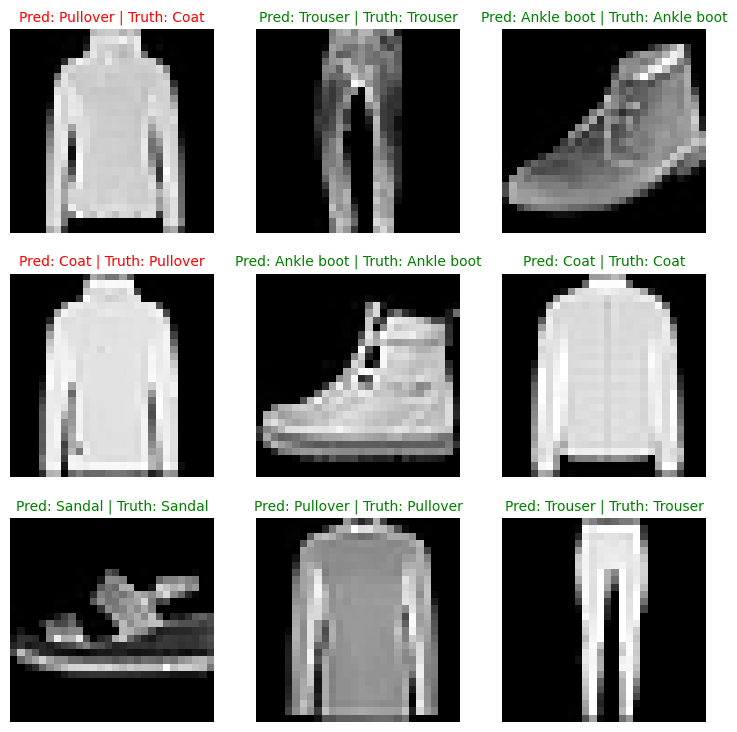

In [79]:
# Plot predictions
matplotlib.pyplot.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  matplotlib.pyplot.subplot(nrows, ncols, i+1)

  # Plot the target image
  matplotlib.pyplot.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = train_data.classes[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = train_data.classes[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      matplotlib.pyplot.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      matplotlib.pyplot.title(title_text, fontsize=10, c="r") # red text if wrong

  matplotlib.pyplot.axis(False)

  # 결과를 보면 Pullover랑 Coat을 헷갈린다거나 하는걸 볼 수 있는데 보면 아주 터무니 없는 건 아니다

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm
import torchmetrics, mlxtend

# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_2(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

# confirm mlxtend version
print(f"mlxtend version: {mlxtend.__version__}")

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(train_data.classes), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=train_data.classes, # turn the row and column labels into class names
    figsize=(10, 7)
);